In [1]:
import pandas as pd

import sentencepiece as spm

from sklearn.metrics import classification_report

import random
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
class MalayalamDataset(Dataset):
    def __init__(self, labels, sentences, tokenizer):
        self.labels = labels
        self.sentences = sentences
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.tokenizer.encode_as_ids(self.sentences[idx])
        label = self.labels[idx]
        return label, torch.tensor(tokens)

In [4]:
df = pd.read_csv("Data/mal_full_offensive_train.csv")
valid_df = pd.read_csv("Data/mal_full_offensive_dev.csv")
test_df = pd.read_csv("Data/mal_offensive_test_with_labels.csv")

In [5]:
df["Labels"].value_counts()

Labels
Not_offensive                           14153
not-malayalam                            1287
Offensive_Targeted_Insult_Individual      239
Offensive_Untargetede                     191
Offensive_Targeted_Insult_Group           140
Name: count, dtype: int64

In [6]:
label_map = {
    "Not_offensive": 0,
    "not-malayalam": 1,
    "Offensive_Targeted_Insult_Individual": 2,
    "Offensive_Untargetede": 3,
    "Offensive_Targeted_Insult_Group": 4
}

In [7]:
df["Labels"] = df["Labels"].map(label_map)
valid_df["Labels"] = valid_df["Labels"].map(label_map)
test_df["Labels"] = test_df["Labels"].map(label_map)

In [8]:
labels = df["Labels"].tolist()
class_counts = torch.bincount(torch.tensor(labels))
class_weights = 1. / class_counts.float()  # inverse frequency
class_weights = class_weights.to(device)

In [9]:
sample_weights = [class_weights[label] for label in labels]

In [10]:
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [11]:
num_classes = df["Labels"].value_counts().shape[0]

In [12]:
num_classes

5

In [13]:
corpus = df["Text"].tolist()
valid_labels = valid_df["Labels"].tolist()
valid_corpus = valid_df["Text"].tolist()
test_labels = test_df["Labels"].tolist()
test_corpus = test_df["Text"].tolist()

In [14]:
tokenizer = spm.SentencePieceProcessor("malayalam_spm.model")

In [15]:
train_data = MalayalamDataset(labels, corpus, tokenizer)
valid_data = MalayalamDataset(valid_labels, valid_corpus, tokenizer)
test_data = MalayalamDataset(test_labels, test_corpus, tokenizer)

In [16]:
'''def label_pipeline(label):
    if label == "Not_offensive":
        return 0
    elif label == "not-malayalam":
        return 1
    elif label == "Offensive_Targeted_Insult_Individual":
        return 2
    elif label == "Offensive_Untargetede":
        return 3
    elif label == "Offensive_Targeted_Insult_Group":
        return 4
    else:
        return -1'''

'def label_pipeline(label):\n    if label == "Not_offensive":\n        return 0\n    elif label == "not-malayalam":\n        return 1\n    elif label == "Offensive_Targeted_Insult_Individual":\n        return 2\n    elif label == "Offensive_Untargetede":\n        return 3\n    elif label == "Offensive_Targeted_Insult_Group":\n        return 4\n    else:\n        return -1'

In [17]:
def collate_fn(batch):
    label_list, text_batch = [], []
    for label, text in batch:
        label_list.append(label)
        text_batch.append(text)
    label_list = torch.tensor(label_list, dtype = torch.int64)
    padded_text = pad_sequence(text_batch, batch_first = True)
    text_list = torch.tensor(padded_text, dtype = torch.int64)
    return label_list.to(device), text_list.to(device)

In [18]:
train_dataloader = DataLoader(train_data, batch_size = 64, collate_fn = collate_fn, sampler = sampler)

In [19]:
valid_dataloader = DataLoader(valid_data, batch_size = 64, shuffle = False, collate_fn = collate_fn)

In [20]:
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = False, collate_fn = collate_fn)

In [21]:
from torch import nn

In [22]:
class OffensiveClassificationModel(nn.Module):
    def __init__(self,vocab_size,embed_dim, hidden_dim, bidirectional, num_class, num_layers = 1, dropout = 0.2):
        super(OffensiveClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, max_norm = 1.0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, bidirectional = bidirectional, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim* (2 if bidirectional else 1), num_classes)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text):
        embedded = self.embedding(text)
        lstm_out, _ = self.lstm(embedded) 
        pooled = lstm_out.mean(dim = 1)
        dropped = self.dropout(pooled)
        return self.fc(dropped)

In [23]:
embed_dim = 128
hidden_dim = 64
bidirectional = True

In [24]:
vocab_size = tokenizer.get_piece_size()
vocab_size

24000

In [25]:
model = OffensiveClassificationModel(vocab_size, embed_dim, hidden_dim, bidirectional, num_classes, num_layers = 2).to(device)
model

OffensiveClassificationModel(
  (embedding): Embedding(24000, 128, max_norm=1.0)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)

In [26]:
learning_rate = 1e-5

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 100, gamma = 0.1)

In [27]:
def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()
    
    plt.show()

In [28]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = model(text)

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [29]:
EPOCHS = 200
cum_loss_list=[]
acc_epoch=[]
acc_old=0

for epoch in tqdm(range(1, EPOCHS + 1)):
    model.train()
    cum_loss=0
    for idx, (label, text) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted_label = model(text)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        cum_loss+=loss.item()

    cum_loss_list.append(cum_loss)
    accu_val = evaluate(valid_dataloader)
    acc_epoch.append(accu_val)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_14532\1594365945.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_list = torch.tensor(padded_text, dtype = torch.int64)
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [06:21<00:00,  1.91s/it]


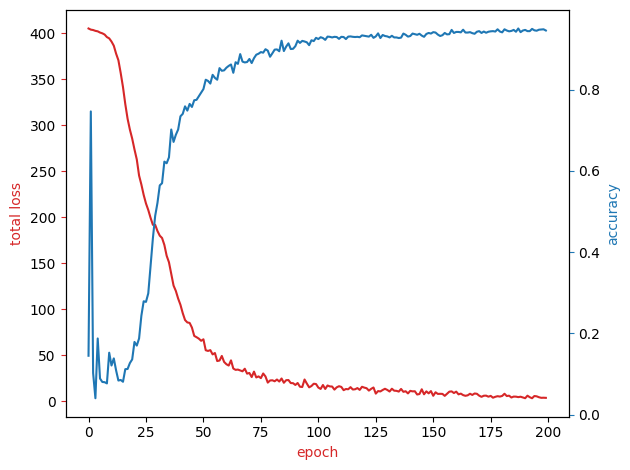

In [30]:
plot(cum_loss_list,acc_epoch)

In [31]:
evaluate(valid_dataloader)

C:\Users\HP\AppData\Local\Temp\ipykernel_14532\1594365945.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_list = torch.tensor(padded_text, dtype = torch.int64)


0.9454727363681841

In [32]:
evaluate(test_dataloader)

C:\Users\HP\AppData\Local\Temp\ipykernel_14532\1594365945.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_list = torch.tensor(padded_text, dtype = torch.int64)


0.9425287356321839

In [33]:
def get_classification_report(model,dataloader):
    model.eval()
    predicted_labels, ground_labels = [], []

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            output = model(text)
            prediction = torch.argmax(output,dim=1)
            predicted_labels.extend(prediction.cpu().numpy())
            ground_labels.extend(label.cpu().numpy())
        cls_report = classification_report(ground_labels,predicted_labels)
    return cls_report

In [34]:
report = get_classification_report(model, test_dataloader)

C:\Users\HP\AppData\Local\Temp\ipykernel_14532\1594365945.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_list = torch.tensor(padded_text, dtype = torch.int64)


In [35]:
print(report)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1765
           1       0.81      0.86      0.83       157
           2       0.62      0.59      0.60        27
           3       0.50      0.62      0.55        29
           4       0.79      0.48      0.59        23

    accuracy                           0.94      2001
   macro avg       0.74      0.70      0.71      2001
weighted avg       0.94      0.94      0.94      2001



In [ ]:
model.save("First_model.pth")